In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [160]:
df = pd.read_csv("class12_career_dataset.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1000, 7)
        Stream                          Core Subjects  Optional Subject  \
0  Science_PCM               Physics, Chemistry, Math           Biology   
1  Science_PCB            Physics, Chemistry, Biology  Computer Science   
2         Arts  History, Political Science, Sociology         Fine Arts   
3  Science_PCM               Physics, Chemistry, Math           Biology   
4         Arts  History, Political Science, Sociology         Fine Arts   

   Hobbies Extracurricular Activities Preferred Career  \
0    Dance              Robotics Club           Doctor   
1    Dance                        MUN       Researcher   
2    Music                 Music Band       Journalist   
3   Poetry                  Olympiads  Biotechnologist   
4  Fitness                  Olympiads          Teacher   

                                    Possible Courses  
0  B.Sc (Biotech), B.Sc (Chemistry), B.Sc (Data S...  
1  B.Sc (Biotech), B.Sc (Chemistry), B.Sc (Data S...  
2  BA (Edu


Column distribution:
Stream
Science_PCMB    222
Science_PCB     202
Commerce        194
Science_PCM     192
Arts            190
Name: count, dtype: int64


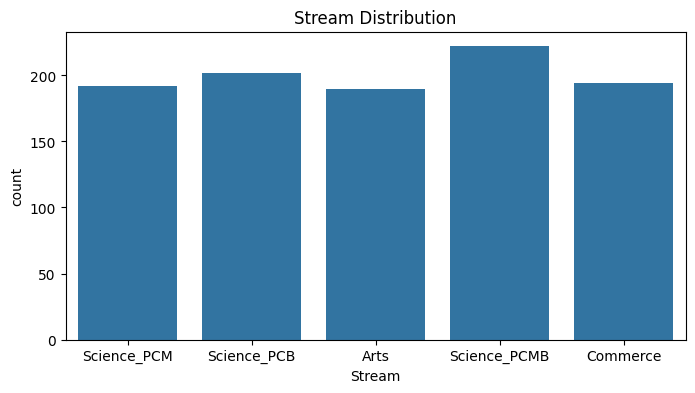

In [161]:
print("\nColumn distribution:")
print(df["Stream"].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x="Stream", data=df)
plt.title("Stream Distribution")
plt.show()

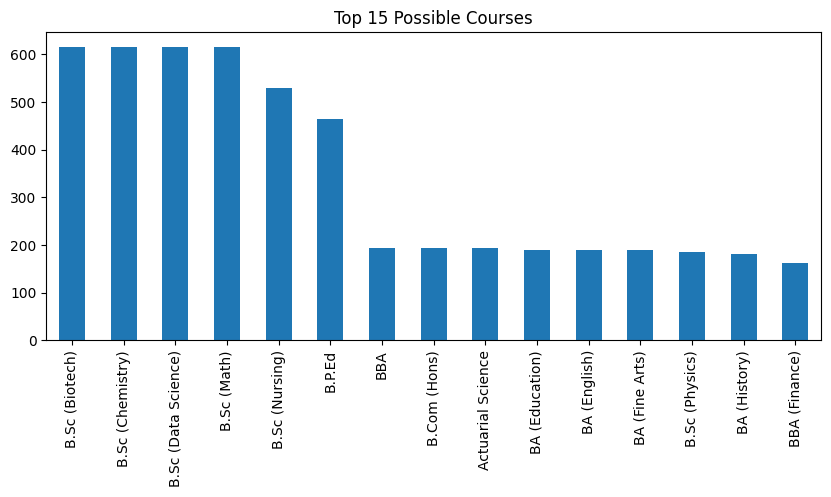

In [162]:
all_courses = [c.strip() for row in df["Possible Courses"] for c in row.split(",")]
course_counts = pd.Series(all_courses).value_counts()

plt.figure(figsize=(10,4))
course_counts[:15].plot(kind="bar")
plt.title("Top 15 Possible Courses")
plt.show()

Stream
Science_PCMB    222
Science_PCB     202
Commerce        194
Science_PCM     192
Arts            190
Name: count, dtype: int64


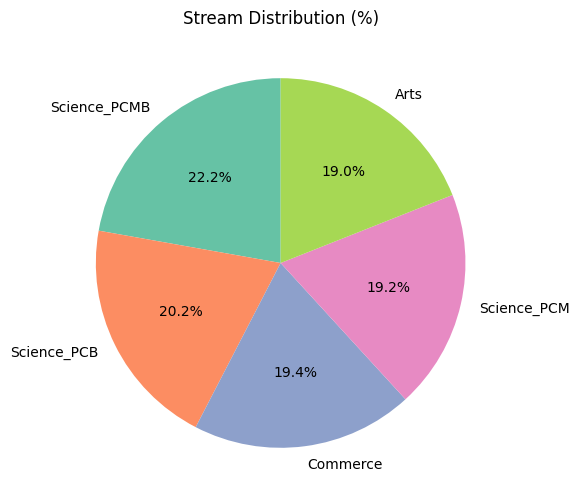

In [163]:
print(df["Stream"].value_counts())
plt.figure(figsize=(6,6))
df["Stream"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title("Stream Distribution (%)")
plt.ylabel("")
plt.show()

In [164]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

# Define X and y
X = df.drop(columns=["Possible Courses"])
y = df["Possible Courses"]

# Identify categorical vs numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(exclude=["object"]).columns

# One-hot encode only categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_categorical = encoder.fit_transform(X[categorical_cols])

# Combine numeric + encoded categorical
X_encoded = pd.concat(
    [
        pd.DataFrame(X[numeric_cols].reset_index(drop=True)),
        pd.DataFrame(X_categorical, columns=encoder.get_feature_names_out(categorical_cols))
    ],
    axis=1
)

# Encode y (target)
#label_encoder_y = LabelEncoder()
#y_encoded = label_encoder_y.fit_transform(y)

print("Shape of Encoded Features:", X_encoded.shape)
print("Sample Encoded Features:")
print(X_encoded.head())


Shape of Encoded Features: (1000, 65)
Sample Encoded Features:
   Stream_Arts  Stream_Commerce  Stream_Science_PCB  Stream_Science_PCM  \
0          0.0              0.0                 0.0                 1.0   
1          0.0              0.0                 1.0                 0.0   
2          1.0              0.0                 0.0                 0.0   
3          0.0              0.0                 0.0                 1.0   
4          1.0              0.0                 0.0                 0.0   

   Stream_Science_PCMB  Core Subjects_Accounts, Business Studies, Economics  \
0                  0.0                                                0.0     
1                  0.0                                                0.0     
2                  0.0                                                0.0     
3                  0.0                                                0.0     
4                  0.0                                                0.0     

   Core Sub

In [165]:
# Split "Possible Courses" into list of courses
y_split = y.apply(lambda x: [c.strip() for c in x.split(",")])

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y_split)

course_labels = mlb.classes_

print("Shape of Target (y_encoded):", y_encoded.shape)
print("Sample Courses:", course_labels[:10])

Shape of Target (y_encoded): (1000, 26)
Sample Courses: ['Actuarial Science' 'B.Com (Hons)' 'B.Ed' 'B.P.Ed' 'B.Sc (Biology)'
 'B.Sc (Biotech)' 'B.Sc (Chemistry)' 'B.Sc (Data Science)' 'B.Sc (IT)'
 'B.Sc (Math)']


In [166]:
# Feature Selection
from sklearn.feature_selection import mutual_info_classif

feature_scores = {}

for i, course in enumerate(course_labels):
    y_course = y_encoded[:, i]   
    
    if y_course.sum() == 0:  
        continue
    
    scores = mutual_info_classif(X_encoded, y_course, discrete_features=True)
    
    for feat, score in zip(X_encoded.columns, scores):
        if feat not in feature_scores:
            feature_scores[feat] = 0
        feature_scores[feat] += score


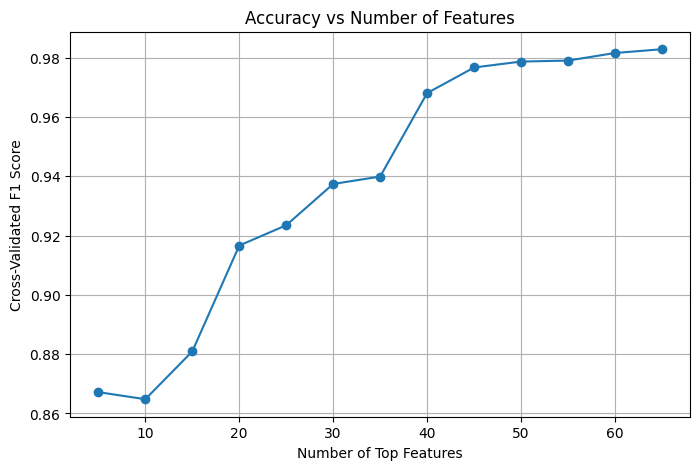

✅ Best number of features: 65 with F1-score: 0.9828


In [167]:
# Ranking features
from sklearn.model_selection import cross_val_score

sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
feat_order = [f[0] for f in sorted_features]
mean_scores = []
k_values = list(range(5, len(feat_order)+1, 5))  # try 5, 10, 15, ...

for k in k_values:
    selected_feats = feat_order[:k]
    X_k = X_encoded[selected_feats]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_k, y_encoded, cv=3, scoring="f1_micro")
    mean_scores.append(np.mean(scores))

# Plot curve
plt.figure(figsize=(8,5))
plt.plot(k_values, mean_scores, marker="o")
plt.title("Accuracy vs Number of Features")
plt.xlabel("Number of Top Features")
plt.ylabel("Cross-Validated F1 Score")
plt.grid(True)
plt.show()

# Best K
best_k = k_values[np.argmax(mean_scores)]
best_score = max(mean_scores)
print(f"✅ Best number of features: {best_k} with F1-score: {best_score:.4f}")


In [168]:
# Take top 50 from already sorted features because it will give nearly similar results with less complexity
top_50_features = [f[0] for f in sorted_features[:50]]
X_top50 = X_encoded[top_50_features]

In [169]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
X = X_top50  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

logreg = OneVsRestClassifier(LogisticRegression(max_iter=500))
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Subset Accuracy:", accuracy_score(y_test, y_pred))
print("Micro F1 Score:", f1_score(y_test, y_pred, average="micro"))
print("Macro F1 Score:", f1_score(y_test, y_pred, average="macro"))
print("Hamming Loss:", hamming_loss(y_test, y_pred))

print("\nClassification Report:\n", 
      classification_report(
          y_test, 
          y_pred, 
          labels=list(range(len(mlb.classes_))),  # ensures full label set
          target_names=mlb.classes_, 
          zero_division=0
      ))



Subset Accuracy: 0.91
Micro F1 Score: 0.91
Macro F1 Score: 0.7801260467927134
Hamming Loss: 0.09

Classification Report:
                           precision    recall  f1-score   support

       Actuarial Science       0.00      0.00      0.00         0
            B.Com (Hons)       0.00      0.00      0.00         0
                    B.Ed       0.00      0.00      0.00         0
                  B.P.Ed       0.00      0.00      0.00         0
          B.Sc (Biology)       0.00      0.00      0.00         0
          B.Sc (Biotech)       0.00      0.00      0.00         0
        B.Sc (Chemistry)       0.00      0.00      0.00         0
     B.Sc (Data Science)       0.00      0.00      0.00         0
               B.Sc (IT)       0.00      0.00      0.00         0
             B.Sc (Math)       0.00      0.00      0.00         0
          B.Sc (Nursing)       0.00      0.00      0.00         0
          B.Sc (Physics)       0.00      0.00      0.00         0
   B.Sc (Sports Sci

In [170]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Define model
logreg = OneVsRestClassifier(LogisticRegression(max_iter=500))

# Cross-validation setup (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Use micro-F1 as scoring (better for multi-label imbalance)
f1_micro = make_scorer(f1_score, average="micro")
hamming = make_scorer(hamming_loss, greater_is_better=False) 

# Cross-validation scores
cv_scores = cross_val_score(logreg, X_top50, y_encoded, cv=kf, scoring=f1_micro)
cv_hamming_scores = cross_val_score(logreg, X_top50, y_encoded, cv=kf, scoring=hamming)

print("Cross-validation F1-micro scores:", cv_scores)
print("Mean F1-micro:", cv_scores.mean())
print("Std Dev:", cv_scores.std())

subset_acc = make_scorer(accuracy_score)
acc_scores = cross_val_score(logreg, X_top50, y, cv=kf, scoring=subset_acc)
print("Mean Subset Accuracy:", acc_scores.mean())

print("\nCross-validation Hamming Loss scores:", -cv_hamming_scores)
print("Mean Hamming Loss:", -cv_hamming_scores.mean())
print("Std Dev Hamming:", cv_hamming_scores.std())


Cross-validation F1-micro scores: [0.99129714 0.99376818 0.99002494 0.99006623 0.99376818]
Mean F1-micro: 0.9917849311232432
Std Dev: 0.0016826163301389269
Mean Subset Accuracy: 0.9259999999999999

Cross-validation Hamming Loss scores: [0.00403846 0.00288462 0.00461538 0.00461538 0.00288462]
Mean Hamming Loss: 0.003807692307692308
Std Dev Hamming: 0.0007825765365144542


In [171]:
# Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Base Decision Tree (wrapped for multi-label classification)
dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))

# Hyperparameter grid
param_grid = {
    "estimator__max_depth": [5, 10, 15, None],     
    "estimator__min_samples_split": [2, 5, 10],    
    "estimator__min_samples_leaf": [1, 2, 5]       
}

# Define scorers
scorers = {
    "f1_micro": make_scorer(f1_score, average="micro"),
    "subset_acc": make_scorer(accuracy_score),
    "hamming_loss": make_scorer(hamming_loss, greater_is_better=False)  
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    dt,
    param_grid,
    scoring=scorers,
    refit="f1_micro",   
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on dataset
grid_search.fit(X_top50, y_encoded)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best CV F1-micro Score:", grid_search.cv_results_['mean_test_f1_micro'][grid_search.best_index_])
print("Best CV Subset Accuracy:", grid_search.cv_results_['mean_test_subset_acc'][grid_search.best_index_])
print("Best CV Hamming Loss:", abs(grid_search.cv_results_['mean_test_hamming_loss'][grid_search.best_index_]))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}
Best CV F1-micro Score: 0.9982505197490763
Best CV Subset Accuracy: 0.9810000000000001
Best CV Hamming Loss: 0.0008076923076923079


In [172]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import numpy as np

# Define Random Forest (wrapped in OneVsRest for multi-label)
rf = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=200,    
        max_depth=15,          #
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1              
    )
)

# Cross-validation setup (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scorers
f1_micro = make_scorer(f1_score, average="micro")
subset_acc = make_scorer(accuracy_score)
hamming = make_scorer(hamming_loss, greater_is_better=False)

# Cross-validation scores
cv_f1_scores = cross_val_score(rf, X_top50, y_encoded, cv=kf, scoring=f1_micro)
cv_acc_scores = cross_val_score(rf, X_top50, y_encoded, cv=kf, scoring=subset_acc)
cv_hamming_scores = cross_val_score(rf, X_top50, y_encoded, cv=kf, scoring=hamming)

# Results
print("Random Forest Cross-validation F1-micro scores:", cv_f1_scores)
print("Mean F1-micro:", cv_f1_scores.mean())
print("Std Dev F1:", cv_f1_scores.std())

print("\nRandom Forest Cross-validation Subset Accuracy scores:", cv_acc_scores)
print("Mean Subset Accuracy:", cv_acc_scores.mean())
print("Std Dev Accuracy:", cv_acc_scores.std())

print("\nRandom Forest Cross-validation Hamming Loss scores:", -cv_hamming_scores)  
print("Mean Hamming Loss:", -cv_hamming_scores.mean())
print("Std Dev Hamming:", cv_hamming_scores.std())


Random Forest Cross-validation F1-micro scores: [0.98151951 0.98277276 0.97814433 0.98029557 0.99173554]
Mean F1-micro: 0.9828935410674854
Std Dev F1: 0.004677348182140697

Random Forest Cross-validation Subset Accuracy scores: [0.835 0.865 0.83  0.825 0.925]
Mean Subset Accuracy: 0.8559999999999999
Std Dev Accuracy: 0.037202150475476585

Random Forest Cross-validation Hamming Loss scores: [0.00865385 0.00807692 0.01019231 0.00923077 0.00384615]
Mean Hamming Loss: 0.008
Std Dev Hamming: 0.0021912953128067868


In [173]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, hamming_loss
import numpy as np

# Make sure X_top50 and y_encoded are numeric
if isinstance(X_top50, pd.DataFrame):
    X_top50 = X_top50.apply(pd.to_numeric, errors="coerce").fillna(0).astype(float).to_numpy()
else:
    X_top50 = np.array(X_top50, dtype=float)
    X_top50 = np.nan_to_num(X_top50, nan=0.0)

y_encoded = np.array(y_encoded, dtype=int)

# Model
xgb = OneVsRestClassifier(
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False
    ),
    n_jobs=-1
)

# Cross-validation setup (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scorers
f1_micro = make_scorer(f1_score, average="micro")
subset_acc = make_scorer(accuracy_score)
ham_loss = make_scorer(hamming_loss, greater_is_better=False)

# Cross-validation scores
cv_f1_scores = cross_val_score(xgb, X_top50, y_encoded, cv=kf, scoring=f1_micro)
cv_acc_scores = cross_val_score(xgb, X_top50, y_encoded, cv=kf, scoring=subset_acc)
cv_hamming_scores = -cross_val_score(xgb, X_top50, y_encoded, cv=kf, scoring=ham_loss)

# Results
print("XGBoost Cross-validation F1-micro scores:", cv_f1_scores)
print("Mean F1-micro:", cv_f1_scores.mean())
print("Std Dev F1:", cv_f1_scores.std())

print("\nXGBoost Cross-validation Subset Accuracy scores:", cv_acc_scores)
print("Mean Subset Accuracy:", cv_acc_scores.mean())
print("Std Dev Accuracy:", cv_acc_scores.std())

print("\nXGBoost Cross-validation Hamming Loss scores:", cv_hamming_scores)
print("Mean Hamming Loss:", cv_hamming_scores.mean())
print("Std Dev Hamming:", cv_hamming_scores.std())




XGBoost Cross-validation F1-micro scores: [0.99293727 0.997921   0.99212598 0.99460805 0.99750623]
Mean F1-micro: 0.9950197058694581
Std Dev F1: 0.002344353325673165

XGBoost Cross-validation Subset Accuracy scores: [0.925 0.98  0.94  0.96  0.97 ]
Mean Subset Accuracy: 0.9549999999999998
Std Dev Accuracy: 0.019999999999999987

XGBoost Cross-validation Hamming Loss scores: [0.00326923 0.00096154 0.00365385 0.0025     0.00115385]
Mean Hamming Loss: 0.002307692307692308
Std Dev Hamming: 0.0010878565864408422


In [174]:
# Fitting 100% of data
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder


# Define final XGBoost model with best parameters from CV
final_xgb = OneVsRestClassifier(
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False  # suppress warning
    ),
    n_jobs=-1
)

# Fit on the full dataset
final_xgb.fit(X_top50, y_encoded)

print("Final XGBoost model trained on 100% of the data")


Final XGBoost model trained on 100% of the data


In [181]:
import joblib

# Save trained model
joblib.dump(final_xgb, "final_xgb_model.joblib")

# Save OneHotEncoder (for X)
joblib.dump(encoder, "feature_encoder.joblib")

# Save MultiLabelBinarizer (for y)
joblib.dump(mlb, "mlb_encoder.joblib")

selected_features = list(map(str, top_50_features))
joblib.dump(selected_features, "selected_features.joblib")




['selected_features.joblib']

In [182]:
def FunctionPredictCourse(InputData):
    """
    Function to predict student stream(s) from new input(s).
    Loads encoders + selected features along with model.
    Returns binary predictions (0/1 per class).
    """
    import pandas as pd
    import joblib

    # Load trained model + encoders + selected features
    xgb_model = joblib.load("final_xgb_model.joblib")
    mlb = joblib.load("mlb_encoder.joblib")                 # MultiLabelBinarizer for target
    encoder = joblib.load("feature_encoder.joblib")         # OneHotEncoder
    selected_features = joblib.load("selected_features.joblib")

    # Step 1: Encode categorical features
    X_encoded = encoder.transform(InputData)

    # Step 2: Convert to DataFrame with proper column names
    # Important: pass InputData.columns so OHE knows what categories map to what
    X_encoded = pd.DataFrame(
        X_encoded,
        columns=encoder.get_feature_names_out(InputData.columns)
    )

    # Step 3: Align with selected features
    selected_features = [str(col) for col in selected_features]  
    for col in selected_features:
        if col not in X_encoded.columns:
            X_encoded[col] = 0   # add missing feature
    X_encoded = X_encoded[selected_features]  # enforce same column order

    # Step 4: Predict
    predictions = xgb_model.predict(X_encoded)

    # Step 5: Convert prediction back to labels
    PredictionLabels = mlb.inverse_transform(predictions)

    # Step 6: Return results
    PredictionResult = pd.DataFrame(predictions, columns=mlb.classes_)
    PredictionResult["Predicted_Courses"] = PredictionLabels

    return PredictionResult




In [183]:
import pandas as pd

# Sample new student 
NewSampleData = pd.DataFrame([
    ["Science", "Physics, Chemistry, Maths", "Computer Science", "Coding", "Robotics", "Software Engineer"],
    ["Commerce", "Accountancy, Business Studies, Economics", "Mathematics", "Reading", "Debating", "Chartered Accountant"],
    ["Arts", "History, Political Science, Sociology", "Psychology", "Drawing", "Drama", "Teacher"],
    ["Science", "Physics, Chemistry, Biology", "Physical Education", "Music", "Sports", "Doctor"],
    ["Commerce", "Accountancy, Business Studies, Economics", "Informatics Practices", "Photography", "Entrepreneurship Club", "Business Analyst"],
    ["Arts", "History, Geography, Literature", "Fine Arts", "Painting", "Theatre", "Artist"],
    ["Science", "Physics, Chemistry, Maths", "Economics", "Gaming", "Quiz Competitions", "Data Scientist"],
    ["Commerce", "Accountancy, Economics, Business Studies", "Legal Studies", "Writing", "MUN (Model UN)", "Lawyer"],
    ["Arts", "Political Science, Sociology, Literature", "Music", "Singing", "Debating", "Journalist"],
    ["Science", "Physics, Chemistry, Maths", "Biology", "Astronomy", "Science Fair", "Researcher"]
], columns=[
    "Stream",
    "Core Subjects",
    "Optional Subject",
    "Hobbies",
    "Extracurricular Activities",
    "Preferred Career"
])

print(NewSampleData)


     Stream                             Core Subjects       Optional Subject  \
0   Science                 Physics, Chemistry, Maths       Computer Science   
1  Commerce  Accountancy, Business Studies, Economics            Mathematics   
2      Arts     History, Political Science, Sociology             Psychology   
3   Science               Physics, Chemistry, Biology     Physical Education   
4  Commerce  Accountancy, Business Studies, Economics  Informatics Practices   
5      Arts            History, Geography, Literature              Fine Arts   
6   Science                 Physics, Chemistry, Maths              Economics   
7  Commerce  Accountancy, Economics, Business Studies          Legal Studies   
8      Arts  Political Science, Sociology, Literature                  Music   
9   Science                 Physics, Chemistry, Maths                Biology   

       Hobbies Extracurricular Activities      Preferred Career  
0       Coding                   Robotics     Softwar

In [184]:
import warnings
warnings.filterwarnings("ignore")
PredictionResult = FunctionPredictCourse(InputData=NewSampleData)
print(PredictionResult)

   Actuarial Science  B.Com (Hons)  B.Ed  B.P.Ed  B.Sc (Biology)  \
0                  0             0     0       0               0   
1                  1             1     0       0               0   
2                  0             0     1       0               0   
3                  0             0     0       1               0   
4                  1             1     0       0               0   
5                  0             0     0       0               0   
6                  0             0     0       0               0   
7                  1             1     0       0               0   
8                  0             0     0       0               0   
9                  0             0     0       0               0   

   B.Sc (Biotech)  B.Sc (Chemistry)  B.Sc (Data Science)  B.Sc (IT)  \
0               1                 1                    1          0   
1               0                 0                    0          0   
2               0                 0   